<a href="https://colab.research.google.com/github/hridog00/RealOrNot/blob/master/ELMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
#! pip install "tensorflow>=1.15,<2.0"
! pip install --upgrade tensorflow-hub

Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.6/dist-packages (0.8.0)


In [3]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout,Input, Lambda
from tensorflow.keras import regularizers, callbacks, optimizers
from tensorflow.keras.optimizers import Adam

import pandas as pd
from keras.utils import to_categorical
import keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
BASE_FOLDER = "/content/drive/My Drive/TFM/"


In [0]:
train_df = pd.read_csv(BASE_FOLDER+"/resources/data/cleaned.csv")

In [0]:
data = train_df[['cleaned_text', 'target', 'text']]
data = data.dropna()

In [0]:
X = data['cleaned_text']
y = to_categorical(data['target'].values)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## ELMO

In [0]:
embed = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [11]:


def build_model(): 
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    dense = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(embedding)
    dense = Dropout(0.3)(dense)
    dense = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005))(dense)
    dense = Dropout(0.3)(dense)
    dense = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005))(dense)
    dense = Dropout(0.3)(dense)
    
    dense = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.005))(dense)
    dense = Dropout(0.3)(dense)

    pred = Dense(2, activation='softmax')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
    return model
model_elmo = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_elmo.fit(X_train, y_train, epochs=50, batch_size=256, validation_split = 0.2)
    model_elmo.save_weights(BASE_FOLDER+'resources/weights/model_elmo_weights.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3999 samples, validate on 1000 samples
Epoch 1/50
3999/3999 [==============================] - 27s 7ms/sample - loss: 1.7302 - acc: 0.4312 - val_loss: 1.6546 - val_acc: 0.4420
Epoch 2/50
3999/3999 [==============================] - 18s 4ms/sample - loss: 1.6752 - acc: 0.4304 - val_loss: 1.6308 - val_acc: 0.4420
Epoch 3/50
3999/3999 [==============================] - 18s 4ms/sample - loss: 1.6373 - acc: 0.4369 - val_loss: 1.6076 - val_acc: 0.4410
Epoch 4/50
3999/3999 [==============================] - 17s 4ms/sample - loss: 1.6123 - acc: 0.4394 - val_loss: 1.5844 - val_acc: 0.4460
Epoch 5/50
3999/3999 [==============================] - 18s 4ms/sample - loss: 1.5859 - acc: 0.4481 - val_loss: 1.5615 - val_acc: 0.4630
Epoch 6/50
3999/3999 [==============================] - 18s 4ms/sample - loss: 1.5587 - acc: 0.4656 - val_loss: 1.5365 - val_acc: 0.4960
Epoch 7/50
3999/3999 [==============================] - 17s 4ms/sample - loss: 1.5338 - acc: 0.4776 - val_loss: 1.5121 - val_acc: 

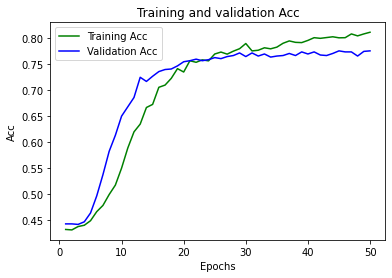

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

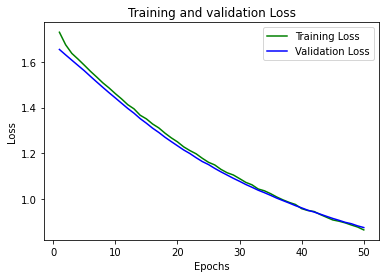

In [14]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo = build_model() 
    model_elmo.load_weights(BASE_FOLDER+'resources/weights/model_elmo_weights.h5')
    import time
    t = time.time()
    results = model_elmo.evaluate(X_test, y_test)
    print("time: ", time.time() - t)
    print(results)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2463/2463 [==============================] - 5s 2ms/sample - loss: 0.7036 - acc: 0.7840
time:  6.002433776855469
[0.7035989327204213, 0.78400326]
